In [1]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset  # Gives easier dataset managment by creating mini batches etc.
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from ViT_model import VisionTransformer

import sys
import seaborn as sns

import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

KeyboardInterrupt: 

In [ ]:
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# elif torch.has_mps:
#     device = torch.device('mps')
# else:
#     device = torch.device('cpu')

device = torch.device('cpu')

print("Device: {}".format(device))

Device: cpu


In [101]:
#read the data 
#algorithm to read all the files

'''
for folder in this folder:
    read xelasensor1.csv
    read sliplabel.csv
    concat it in a single dataframe along axis = 0

print the dataframe
'''

directory = 'train2dof'
directory2 = '/Users/elijahnelson/Desktop/SIWES/IML/Tactile_IML/'

def read_file(detect_or_pred, n = None):

    #store all directories in a list
    list_xela_allfiles = []
    list_sliplabel_allfiles = []

    for root, subdirectories, files in os.walk(directory):
        for sdirectory in subdirectories:

            #subdirectory with absolute path
            subdirectory = '{}/{}'.format(root, sdirectory)

            #read specific files in the subdirectory
            for file in os.listdir(subdirectory):
            
                if not file.startswith(".") and file.endswith("sensor1.csv"):
                    df = pd.read_csv(f'{subdirectory}/{file}', index_col=None, header=0)
                    
                    if detect_or_pred ==0:
                        list_xela_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None:
                        list_xela_allfiles.append(df[:-n])

                if not file.startswith(".") and file.endswith("label.csv"):
                    df = pd.read_csv('{}/{}'.format(subdirectory, file), index_col=None, header=0)
                    if detect_or_pred ==0:
                        list_sliplabel_allfiles.append(df)
                    elif detect_or_pred ==1 and n is not None: 
                        list_sliplabel_allfiles.append(df[n:])

    return list_xela_allfiles, list_sliplabel_allfiles

    #np.newaxis; np.zeros (3,4,4) -> 
                    


In [102]:
#concat the list of xela_allfiles and sliplabel_allfiles across axis = 0
n = 20
# list_xela_allfiles, list_sliplabel_allfiles = read_file(0)

#for slip prediction, comment the line above and uncomment the line below
list_xela_allfiles, list_sliplabel_allfiles = read_file(1, n)

pd_xela_allfiles = pd.concat(list_xela_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd.concat(list_sliplabel_allfiles, axis=0, ignore_index=True)
pd_sliplabel_allfiles = pd_sliplabel_allfiles['slip']

#reshape the target array into (rows, 1)
tac_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)


In [103]:
#arrange the data by 3, 4, 4

#arrange the columns by x, y, z
col_x = []
col_y = []
col_z = []

pd_columns = pd_xela_allfiles.columns
for col in pd_columns:
    if col.endswith('x'):
        col_x.append(col)
    
    elif col.endswith('y'):
        col_y.append(col)
    
    elif col.endswith('z'):
        col_z.append(col)

#arrange the table using the arranged columns
pd_xela_allfiles_x = pd_xela_allfiles[col_x]
pd_xela_allfiles_y = pd_xela_allfiles[col_y]
pd_xela_allfiles_z = pd_xela_allfiles[col_z]


#scale the data in the arranged columns
#scale the data of the features

sc = MinMaxScaler() #standard scaler
sc.fit(pd_xela_allfiles_x)
pd_xela_allfiles_x = sc.transform(pd_xela_allfiles_x)

sc.fit(pd_xela_allfiles_y)
pd_xela_allfiles_y = sc.transform(pd_xela_allfiles_y)

sc.fit(pd_xela_allfiles_z)
pd_xela_allfiles_z = sc.transform(pd_xela_allfiles_z)



#reshape the arranged data per row to (4,4) AND rotate 90 degree anti-clockwise and append to a list
pd_x = []
pd_y = []
pd_z = []

for row in range(len(pd_xela_allfiles_x)):
    pd_x.append(np.rot90(pd_xela_allfiles_x[row].reshape(4,4)))
    pd_y.append(np.rot90(pd_xela_allfiles_y[row].reshape(4,4)))
    pd_z.append(np.rot90(pd_xela_allfiles_z[row].reshape(4,4)))

#add all the x, y, z in a single list
pd_main = [pd_x, pd_y, pd_z]

#arrange pd_main in a 3, 4, 4 array where its 3(4, 4) of x, y, z values
pd_image = np.zeros( (pd_xela_allfiles.shape[0], 3, 4, 4))

#per row, get (4,4) of x, y, z and assign it to pd_image to form the image
for row in range(pd_xela_allfiles.shape[0]):
    x_4_4 = pd_main[0][row]
    y_4_4 = pd_main[1][row]
    z_4_4 = pd_main[2][row]

    pd_image[row][0] = x_4_4
    pd_image[row][1] = y_4_4
    pd_image[row][2] = z_4_4


In [104]:
pd_label = pd_sliplabel_allfiles.values.reshape(pd_sliplabel_allfiles.shape[0], 1)

In [105]:
pd_image = torch.from_numpy(pd_image.astype(np.float32))
pd_label = torch.from_numpy(pd_label.astype(np.float32))

In [106]:
pd_image.shape, pd_label.shape

(torch.Size([215111, 3, 4, 4]), torch.Size([215111, 1]))

In [107]:
class seq_dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.__len__()
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [108]:
valid_dataset = seq_dataset(pd_image, pd_label)
valid_loader = DataLoader(valid_dataset, batch_size=8192, shuffle=True, drop_last=True)

In [109]:
for i in valid_loader:
    x_try = i[0]
    print(i[0].shape, i[1].shape)
    break

torch.Size([8192, 3, 4, 4]) torch.Size([8192, 1])


In [4]:
import torch
from ViT_model import VisionTransformer
device = torch.device('cpu')
n = 15

model = VisionTransformer(image_size=4, patch_size=1, in_chans=3, n_classes=1,
                  embed_dim=32, depth=2, n_heads=2, mlp_ratio=1., 
                  qkv_bias=True, p=0.1, attn_p=0.1, proj_p=0.1).to(device)

model.load_state_dict(torch.load(f'ViT_n{n}.pth', map_location=device))

model

/var/folders/2v/kf1_w44n4h7d8y01qynvcqhm0000gn/T/ipykernel_54231/298020691.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'ViT_n{n}.p

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-1): 2 x Block(
      (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (attention): Attention(
        (qkv): Linear(in_features=32, out_features=96, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=32, out_features=32, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=32, out_features=32, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=32, out_features=32, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
  (head): Linear(in_features=32, out_features=1, bias=True)
)

In [111]:
y_pred = []
y_true = []
model.eval()
for (x,y) in (valid_loader):
        with torch.no_grad():
                y_true.append(y.detach().cpu().numpy())
                y_pred_test = torch.sigmoid(model(x))
                y_pred.append(y_pred_test.detach().cpu().numpy()) 

In [112]:
y_pred = y_pred[:-1]
y_true = y_true[:-1]

In [113]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

In [114]:
y_pred = np.expand_dims(y_pred.flatten().round(), -1)
y_true = np.expand_dims(y_true.flatten(), -1)

In [115]:
y_pred.shape, y_true.shape

((204800, 1), (204800, 1))

In [116]:
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(f'recall: {recall_score(y_true, y_pred)}')
print(f'precision: {precision_score(y_true, y_pred)}')
print(f'f1: {f1_score(y_true, y_pred)}')

accuracy: 0.9455029296875
recall: 0.6408615384615385
precision: 0.6616684668657475
f1: 0.651098815217731


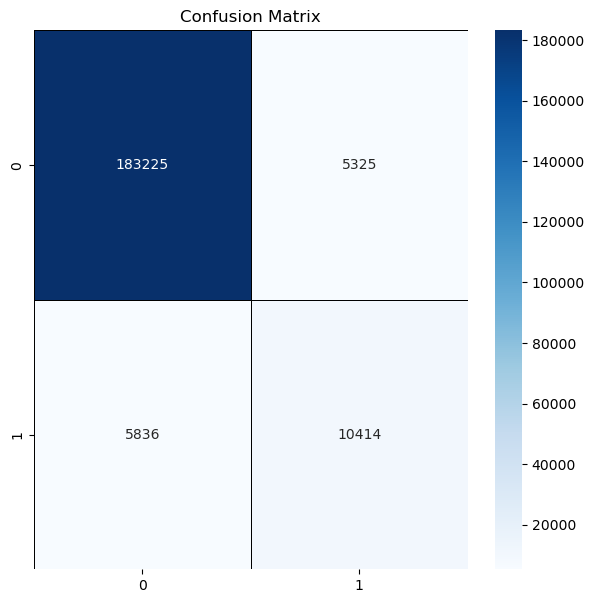

In [117]:
plt.figure(figsize=(7,7))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_true, y_pred), cmap='Blues', annot=True, linecolor='black', linewidth=0.5, fmt='')
plt.show()